In [2]:
!pip install mlflow

# All required commands to install MLflow on EC2

In [3]:
# Test mlflow

import mlflow

mlflow.set_tracking_uri("http://ec2-13-220-153-19.compute-1.amazonaws.com:5000/")

with mlflow.start_run():
  mlflow.log_param("param1", 420)
  mlflow.log_metric("metric1", 0.69)

🏃 View run wise-calf-634 at: http://ec2-13-220-153-19.compute-1.amazonaws.com:5000/#/experiments/0/runs/60bda73fbcc24fd8a931d45c4f8f75c5
🧪 View experiment at: http://ec2-13-220-153-19.compute-1.amazonaws.com:5000/#/experiments/0


In [4]:
# Creating baseline model

import numpy as np
import pandas as pd

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv")
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [6]:
df.dropna(inplace=True)

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df = df[~(df['clean_comment'].str.strip() == '')]

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [10]:
# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# Define the preprocessing function

def preprocess_comment(comment):
  comment = comment.lower()
  comment = comment.strip()
  comment = re.sub(r'\n','. ',comment)
  comment = re.sub(r'[^A-Za-z0-9\s!?.,]','',comment)
  stop_words = set(stopwords.words('english')) - {'not', 'no', 'but', 'however', 'yet'}
  comment = ' '.join([word for word in comment.split() if word not in stop_words])
  lemmatizer = WordNetLemmatizer()
  comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])
  return comment



In [12]:
# Apply the preprocessing function to the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)

In [13]:
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [14]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Step 1: Vectorize the comments using Bag Of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=10000)

In [16]:
x = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category'] # Assuming 'sentiment' is the target variable (0 or 1 binary classification)

In [17]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
x.shape

(36793, 10000)

In [19]:
y

,category
0,1
1,1
2,-1
3,0
4,1
...,...
37244,0
37245,1
37246,0
37247,1


In [20]:
y.shape

(36793,)

In [21]:
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-13-220-153-19.compute-1.amazonaws.com:5000/")

In [22]:
# Set or create an experiment
mlflow.set_experiment("RF Baseline")

<Experiment: artifact_location='s3://mlflow-bucket-27/308588228745729059', creation_time=1750350778549, experiment_id='308588228745729059', last_update_time=1750350778549, lifecycle_stage='active', name='RF Baseline', tags={}>

In [23]:
!pip install boto3 awscli

In [24]:
!aws configure

AWS Access Key ID [****************FZEB]: 
AWS Secret Access Key [****************kiH4]: 
Default region name [us-east-1]: 
Default output format [None]: 


2025/06/19 18:28:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/19 18:28:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_Baseline_TrainTestSplit at: http://ec2-13-220-153-19.compute-1.amazonaws.com:5000/#/experiments/308588228745729059/runs/37adbe5c28c14989babc2c1ec7277409
🧪 View experiment at: http://ec2-13-220-153-19.compute-1.amazonaws.com:5000/#/experiments/308588228745729059
Accuracy: 0.6451963582008425


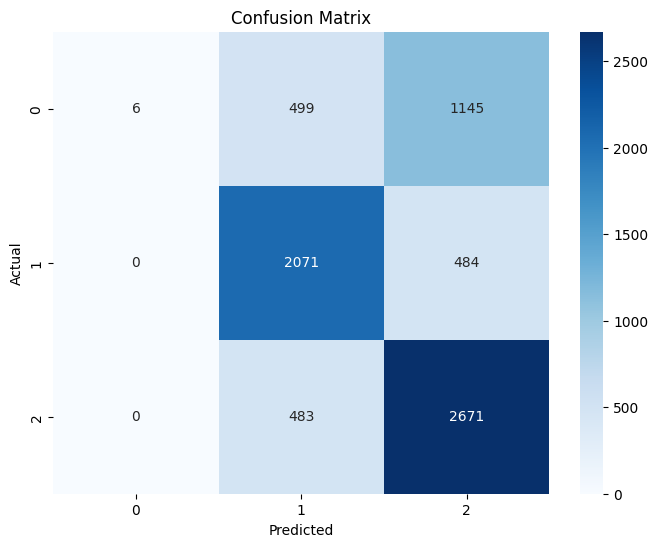

In [25]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run() as run:
  # Log a description for the run
  mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
  mlflow.set_tag("experiment_type", "baseline")
  mlflow.set_tag("model_type", "RandomForestClassifier")

  # Add a description
  mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using BoW with a simple train-test split")

  # Log parameters for the vectorizer
  mlflow.log_param("vectorizer_type", "CountVectorizer")
  mlflow.log_param("max_features", vectorizer.max_features)

  # Log Random Forest parameters
  n_estimators = 200
  max_depth = 15

  mlflow.log_param("n_estimators", n_estimators)
  mlflow.log_param("max_depth", max_depth)

  # Initialize and train the model
  model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
  model.fit(x_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(x_test)

  # Log metrics for each class and accuracy
  accuracy = accuracy_score(y_test, y_pred)
  mlflow.log_metric("accuracy", accuracy)

  classification_rep = classification_report(y_test, y_pred, output_dict=True)

  for label, metrics in classification_rep.items():
    if isinstance(metrics, dict): # For precision, recall, f1-score, etc.
      for metric, value in metrics.items():
        mlflow.log_metric(f"{label}_{metric}", value)

  # Confusion matrix plot
  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')

  # Save and log the confusion matrix plot
  plt.savefig('confusion_matrix.png')
  mlflow.log_artifact('/content/confusion_matrix.png')

  # Log the Random Forest model
  mlflow.sklearn.log_model(model, "random_forest_model")

  # Log the dataset itself (if it's small enough)
  df.to_csv('dataset.csv', index=False)
  mlflow.log_artifact('/content/dataset.csv')

# Display final accuracy
print(f"Accuracy: {accuracy}")

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.00      0.01      1650
           0       0.68      0.81      0.74      2555
           1       0.62      0.85      0.72      3154

    accuracy                           0.65      7359
   macro avg       0.77      0.55      0.49      7359
weighted avg       0.73      0.65      0.57      7359



In [27]:
df.to_csv('reddit_preprocessing.csv', index=False)